In [1]:
import time
import glob
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

In [2]:
class Extract_Time_Features:    
    def __init__(self, rawTimeData):
        self._TimeFeatures = []
        self._rawTimeData = rawTimeData

    def AbsMax(self):
        self._absmax = np.abs(self._rawTimeData).max(axis=1)
        return self._absmax
    
    def AbsMean(self):
        self._absmean = np.abs(self._rawTimeData).mean(axis=1)
        return self._absmean
    
    def P2P(self):
        self._peak2peak = np.max(self._rawTimeData,axis=1) - np.min(self._rawTimeData,axis=1)
        return self._peak2peak
    
    def Skewness(self):
        self._skewness = skew(self._rawTimeData, axis=1, nan_policy='raise')
        return self._skewness
    
    def Kurtosis(self):
        self._kurtosis = kurtosis(self._rawTimeData, axis=1, fisher=False)
        return self._kurtosis

    def RMS(self):
        self._rms = np.sqrt(np.sum(self._rawTimeData**2, axis=1) / self._rawTimeData.shape[1])
        return self._rms
    
    def CrestFactor(self):
        self._cresfactor = self.P2P() / self.RMS()
        return self._cresfactor
    
    def ShapeFactor(self):
        self._shapefactor = self.RMS() / self.AbsMean()
        return self._shapefactor
    
    def ImpulseFactor(self):
        self._impulsefactor = self.AbsMax() / self.AbsMean()
        return self._impulsefactor

    def Features(self):
        # Time-domain Features #
        self._TimeFeatures.append(self.AbsMax())        # Feature 1: Absolute Maximum 
        self._TimeFeatures.append(self.AbsMean())       # Feature 2: Absolute Mean
        self._TimeFeatures.append(self.P2P())           # Feature 3: Peak-to-Peak
        self._TimeFeatures.append(self.RMS())           # Feature 4: Root-mean-square
        self._TimeFeatures.append(self.Skewness())      # Feature 5: Skewness
        self._TimeFeatures.append(self.Kurtosis())      # Feature 6: Kurtosis
        self._TimeFeatures.append(self.CrestFactor())   # Feature 7: Crest Factor
        self._TimeFeatures.append(self.ShapeFactor())   # Feature 8: Shape Factor
        self._TimeFeatures.append(self.ImpulseFactor()) # Feature 9: Impulse Factor
                
        return np.asarray(self._TimeFeatures)

In [3]:
#%%  Define class for phase feature extraction ##
class Extract_Phase_Features:    
    def __init__(self, rawTimeData, Fs):
        self._PhaseFeatures = []
        self._rawTimeData = rawTimeData - np.expand_dims(np.mean(rawTimeData,axis=1),axis=1) # Raw time data
        self._Fs = Fs                    # Sampling frequency [Hz]
        
        # Phase Shift #
    
    def Shift(self):
        
        _r = self._rawTimeData[0]
        _s = self._rawTimeData[1]
        _t = self._rawTimeData[2]
        
        _N = self._rawTimeData.shape[1]
        
        _t = np.linspace(0.0, ((_N - 1) / self._Fs), _N)
        _dts = np.linspace(-_t[-1], _t[-1], (2 * _N) - 1)
        
        # RS Phase shift
        self._RS_corr = np.correlate(_r, _s, 'full')
        self._RS_t = _dts[self._RS_corr.argmax()]
        self._RS_phase = ((2.0 * np.pi) * ((self._RS_t / (1.0 / self._Fs)) % 1.0)) - np.pi
        
        # ST Phase shift
        self._ST_corr = np.correlate(_s, _t, 'full')
        self._ST_t = _dts[self._ST_corr.argmax()]
        self._ST_phase = ((2.0 * np.pi) * ((self._ST_t / (1.0 / self._Fs)) % 1.0)) - np.pi
        
         # TR Phase shift
        self._TR_corr = np.correlate(_t, _r, 'full')
        self._TR_t = _dts[self._TR_corr.argmax()]
        self._TR_phase = ((2.0 * np.pi) * ((self._TR_t / (1.0 / self._Fs)) % 1.0)) - np.pi
        
        # Phase Level shift
        self._RS_level = _r.max() - _s.max()
        self._ST_level = _s.max() - _t.max()
        self._TR_level = _t.max() - _r.max()
        
        return (self._RS_phase, self._ST_phase, self._TR_phase, self._RS_level, self._ST_level, self._TR_level)
    
    
    def Features(self):
        shift = self.Shift()
        
        self._PhaseFeatures.append(shift[0])
        self._PhaseFeatures.append(shift[1])
        self._PhaseFeatures.append(shift[2])
        self._PhaseFeatures.append(shift[3])
        self._PhaseFeatures.append(shift[4])
        self._PhaseFeatures.append(shift[5])
        
        return np.asarray(self._PhaseFeatures)    

In [4]:
#%%  Define class for frequency feature extraction ##
class Extract_Freq_Features:    
    def __init__(self, rawTimeData, rpm, Fs):
        self._FreqFeatures = []
        # Remove bias (subtract mean by each channel) #
        self._rawTimeData = rawTimeData - np.expand_dims(np.mean(rawTimeData,axis=1),axis=1) # Raw time data
        
        self._Fs = Fs                    # Sampling frequency [Hz]
        self._rpm = rpm/60               # RPM for every second [Hz]
       
    def FFT(self):
        # Perform FFT #
        _N = self._rawTimeData.shape[1]
        _dt = 1/self._Fs
        _yf_temp = np.fft.fft(self._rawTimeData)
        self._yf = np.abs(_yf_temp[:,:int(_N/2)]) / (_N/2)
        self._xf = np.fft.fftfreq(_N, d=_dt)[:int(_N/2)]
        
        return self._xf, self._yf
    
    def Freq_IDX(self):
        _xf,_yf = self.FFT()
        
        # Motor #
        # find frequency index of 1x #
        self._Freq_1x = self._rpm
        self._1x_idx_Temp = abs(_xf - self._Freq_1x).argmin()
        self._1x_idx_Temp = self._1x_idx_Temp - 2 + np.argmax(self._yf[0][np.arange(self._1x_idx_Temp-2, self._1x_idx_Temp+3)])
        self._1x_idx = np.arange(self._1x_idx_Temp-1, self._1x_idx_Temp+2)

        # find frequency index of 2x #
        self._Freq_2x = self._xf[self._1x_idx[1]] * 2
        self._2x_idx_Temp = abs(_xf - self._Freq_2x).argmin()
        self._2x_idx_Temp = self._2x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._2x_idx_Temp-5, self._2x_idx_Temp+6)])
        self._2x_idx = np.arange(self._2x_idx_Temp-1, self._2x_idx_Temp+2)
        
        # find frequency index of 3x #
        self._Freq_3x = self._xf[self._1x_idx[1]] * 3
        self._3x_idx_Temp = abs(_xf - self._Freq_3x).argmin()
        self._3x_idx_Temp = self._3x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._3x_idx_Temp-5, self._3x_idx_Temp+6)])
        self._3x_idx = np.arange(self._3x_idx_Temp-1, self._3x_idx_Temp+2)
        
        # find frequency index of 4x #
        self._Freq_4x = self._xf[self._1x_idx[1]]  * 4
        self._4x_idx_Temp = abs(_xf - self._Freq_4x).argmin()
        self._4x_idx_Temp = self._4x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._4x_idx_Temp-5, self._4x_idx_Temp+6)])
        self._4x_idx = np.arange(self._4x_idx_Temp-1, self._4x_idx_Temp+2)
        
        
        return (self._1x_idx, self._2x_idx, self._3x_idx, self._4x_idx)

    def Features(self):
        _xf, _yf = self.FFT()
        idx = self.Freq_IDX()
                
        # Freq-domain Features #
        self._1x_Feature = np.sum(_yf[:, idx[0]], axis=1) 
        self._2x_Feature = np.sum(_yf[:, idx[1]], axis=1) 
        self._3x_Feature = np.sum(_yf[:, idx[2]], axis=1) 
        self._4x_Feature = np.sum(_yf[:, idx[3]], axis=1)
                
        self._FreqFeatures.append(self._1x_Feature)
        self._FreqFeatures.append(self._2x_Feature)
        self._FreqFeatures.append(self._3x_Feature)
        self._FreqFeatures.append(self._4x_Feature)
        
        return np.asarray(self._FreqFeatures)

In [5]:
def validation(filename):
    cur = pd.read_csv(filename, header=None, skiprows=9)
    cur = np.asarray(cur)[:,1:4].transpose()
    
    date = pd.read_csv(filename, header=None, skiprows=0, nrows=1)
    date = date[1]

    meta = pd.read_csv(filename, header=None, skiprows=4, nrows=1)
    rpm = int(meta[2])

    fs = pd.read_csv(filename, header=None, skiprows=6, nrows=1)
    Fs = int(fs[1])

    TimeFeatureExtractor = Extract_Time_Features(cur)
    features_time = TimeFeatureExtractor.Features().flatten()

    PhaseFeatureExtractor = Extract_Phase_Features(cur, Fs)
    features_phase = PhaseFeatureExtractor.Features().flatten()
    FreqFeatureExtractor = Extract_Freq_Features(cur, rpm, Fs)
    features_freq = FreqFeatureExtractor.Features().flatten()

    y = pd.read_csv(filename, header=None, skiprows=3, nrows=1)
    y = y[1]

    dataset = np.concatenate((date, features_time, features_phase, features_freq, meta[3], y))
    
    return dataset

# current 일반

In [9]:
datapath = glob.glob("C:/Users/qhrrl/CodeExamples/current_ai/cur_training_2.2/" + '*/**/*.csv', recursive=True)

In [10]:
len(datapath)

305534

In [12]:
dataset_list = []

for file in datapath:
    dataset = validation(file)
    dataset_list.append(dataset)

In [13]:
len(dataset_list)

305534

In [14]:
pd_dataset = pd.DataFrame(dataset_list)

In [15]:
pd_dataset.head(3)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,2020-11-13 07:43:41,3.643555,3.883789,4.124023,2.152260,2.154582,2.290735,7.126953,7.527344,7.687500,...,3.553066,3.763136,0.021705,0.023957,0.020911,0.057528,0.057195,0.057517,2.2,0
1,2020-11-13 07:43:41,3.643555,3.803711,4.164062,2.161249,2.163811,2.301946,7.126953,7.447266,7.727539,...,3.533756,3.747315,0.009876,0.010175,0.010687,0.011616,0.013211,0.010941,2.2,0
2,2020-11-13 07:43:41,3.683594,3.803711,4.164062,2.152920,2.151939,2.289333,7.166992,7.367188,7.727539,...,3.519853,3.728701,0.017622,0.011568,0.014016,0.012954,0.016530,0.011328,2.2,0


In [16]:
pd_dataset.columns = [
        'Date',
        'R_AbsMax', 'S_AbsMax', 'T_AbsMax', 'R_AbsMean', 'S_AbsMean','T_AbsMean',
        'R_P2P', 'S_P2P', 'T_P2P', 'R_RMS', 'S_RMS', 'T_RMS', 
        'R_Skewness', 'S_Skewness', 'T_Skewness', 'R_Kurtosis', 'S_Kurtosis', 'T_Kurtosis',
        'R_Crest', 'S_Crest', 'T_Crest', 'R_Shape', 'S_Shape', 'T_Shape',
        'R_Impulse', 'S_Impulse', 'T_Impulse',
        'RS_phase', 'ST_phase', 'TR_phase', 'RS_Level', 'ST_Level', 'TR_Level',
        'R_1x', 'S_1x', 'T_1x', 'R_2x', 'S_2x', 'T_2x',
        'R_3x', 'S_3x', 'T_3x', 'R_4x', 'S_4x', 'T_4x',
        'WATT','LABEL'
        ]

In [17]:
pd_dataset

,Date,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,...,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x,WATT,LABEL
0,2020-11-13 07:43:41,3.643555,3.883789,4.124023,2.152260,2.154582,2.290735,7.126953,7.527344,7.687500,...,3.553066,3.763136,0.021705,0.023957,0.020911,0.057528,0.057195,0.057517,2.2,0
1,2020-11-13 07:43:41,3.643555,3.803711,4.164062,2.161249,2.163811,2.301946,7.126953,7.447266,7.727539,...,3.533756,3.747315,0.009876,0.010175,0.010687,0.011616,0.013211,0.010941,2.2,0
2,2020-11-13 07:43:41,3.683594,3.803711,4.164062,2.152920,2.151939,2.289333,7.166992,7.367188,7.727539,...,3.519853,3.728701,0.017622,0.011568,0.014016,0.012954,0.016530,0.011328,2.2,0
3,2020-11-13 07:44:42,3.553467,3.753662,3.993896,2.134172,2.111470,2.258483,6.966797,7.247070,7.487305,...,3.359254,3.581625,0.011735,0.008646,0.012069,0.008928,0.008072,0.006405,2.2,0
4,2020-11-13 07:44:42,3.593506,3.713623,4.073975,2.137425,2.114743,2.260646,7.006836,7.247070,7.607422,...,3.354816,3.573826,0.007737,0.006841,0.007718,0.011826,0.016674,0.015070,2.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305529,2021-01-27 00:47:02,3.803711,4.003906,4.003906,2.252598,2.304028,2.266311,7.567383,7.927734,7.807617,...,3.684790,3.580361,0.093621,0.091038,0.093348,0.007971,0.003863,0.006197,2.2,0
305530,2021-01-27 00:47:02,3.763672,4.003906,4.003906,2.255460,2.308152,2.267592,7.527344,7.927734,7.767578,...,3.668430,3.571321,0.089815,0.083217,0.092134,0.010085,0.006868,0.008668,2.2,0
305531,2021-01-27 00:50:55,3.723633,3.963867,3.963867,2.237843,2.294679,2.255941,7.447266,7.847656,7.727539,...,3.762358,3.654498,0.092995,0.092244,0.094533,0.010208,0.029431,0.030930,2.2,0
305532,2021-01-27 00:50:55,3.763672,3.923828,3.963867,2.236702,2.291616,2.252798,7.487305,7.807617,7.727539,...,3.755750,3.648903,0.103550,0.101582,0.107555,0.008367,0.001673,0.008206,2.2,0


<AxesSubplot:xlabel='LABEL', ylabel='count'>

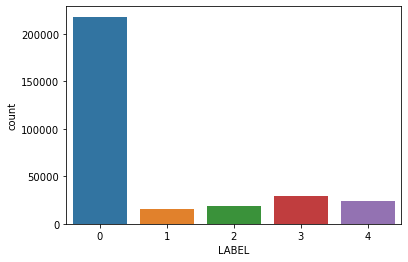

In [18]:
import seaborn as sns

sns.countplot(x='LABEL', data=pd_dataset)

In [19]:
pd_dataset.to_csv('2.2kW_ALL_training_with_label.csv', index=False)

# Current_ val

In [20]:
val_datapath = glob.glob("C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2/" + '*/**/*.csv', recursive=True)

In [21]:
len(val_datapath)

38210

In [22]:
val_datapath

['C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201105_002.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201106_002.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201107_002.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201205_002.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201206_002.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201207_002.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201305_002.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/cur_validation_2.2\\L-DEF-01\\정상\\STFCB-20201012-0105-0138_20201104_201306_00

In [23]:
dataset_list_val = []

for file in val_datapath:
    dataset_val = validation(file)
    dataset_list_val.append(dataset_val)

In [24]:
len(dataset_list_val)

38210

In [25]:
pd_val_dataset = pd.DataFrame(dataset_list_val)

In [26]:
pd_val_dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,2020-11-04 20:12:54,3.793701,3.793701,4.154053,2.205342,2.169747,2.309003,7.327148,7.447266,7.727539,...,3.417413,3.626784,0.011671,0.012673,0.015285,0.014712,0.013995,0.008425,2.2,0
1,2020-11-04 20:12:54,3.673584,3.793701,4.154053,2.201408,2.165643,2.310865,7.207031,7.367188,7.687500,...,3.443414,3.666574,0.007045,0.007379,0.006799,0.006815,0.015612,0.010616,2.2,0
2,2020-11-04 20:12:54,3.673584,3.833740,4.154053,2.197003,2.162560,2.308042,7.207031,7.407227,7.727539,...,3.443272,3.664395,0.013236,0.011662,0.011017,0.014893,0.014687,0.008664,2.2,0
3,2020-11-04 20:13:52,3.803711,3.803711,4.164062,2.205392,2.169797,2.309413,7.327148,7.447266,7.727539,...,3.417413,3.626784,0.011671,0.012673,0.015285,0.014712,0.013995,0.008425,2.2,0
4,2020-11-04 20:13:52,3.683594,3.803711,4.164062,2.201448,2.165733,2.311195,7.207031,7.367188,7.687500,...,3.443414,3.666574,0.007045,0.007379,0.006799,0.006815,0.015612,0.010616,2.2,0


In [27]:
pd_val_dataset.columns = [
        'Date',
        'R_AbsMax', 'S_AbsMax', 'T_AbsMax', 'R_AbsMean', 'S_AbsMean','T_AbsMean',
        'R_P2P', 'S_P2P', 'T_P2P', 'R_RMS', 'S_RMS', 'T_RMS', 
        'R_Skewness', 'S_Skewness', 'T_Skewness', 'R_Kurtosis', 'S_Kurtosis', 'T_Kurtosis',
        'R_Crest', 'S_Crest', 'T_Crest', 'R_Shape', 'S_Shape', 'T_Shape',
        'R_Impulse', 'S_Impulse', 'T_Impulse',
        'RS_phase', 'ST_phase', 'TR_phase', 'RS_Level', 'ST_Level', 'TR_Level',
        'R_1x', 'S_1x', 'T_1x', 'R_2x', 'S_2x', 'T_2x',
        'R_3x', 'S_3x', 'T_3x', 'R_4x', 'S_4x', 'T_4x',
        'WATT','LABEL'
        ]

In [28]:
pd_val_dataset.head(3)

,Date,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,...,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x,WATT,LABEL
0,2020-11-04 20:12:54,3.793701,3.793701,4.154053,2.205342,2.169747,2.309003,7.327148,7.447266,7.727539,...,3.417413,3.626784,0.011671,0.012673,0.015285,0.014712,0.013995,0.008425,2.2,0
1,2020-11-04 20:12:54,3.673584,3.793701,4.154053,2.201408,2.165643,2.310865,7.207031,7.367188,7.687500,...,3.443414,3.666574,0.007045,0.007379,0.006799,0.006815,0.015612,0.010616,2.2,0
2,2020-11-04 20:12:54,3.673584,3.833740,4.154053,2.197003,2.162560,2.308042,7.207031,7.407227,7.727539,...,3.443272,3.664395,0.013236,0.011662,0.011017,0.014893,0.014687,0.008664,2.2,0


<AxesSubplot:xlabel='LABEL', ylabel='count'>

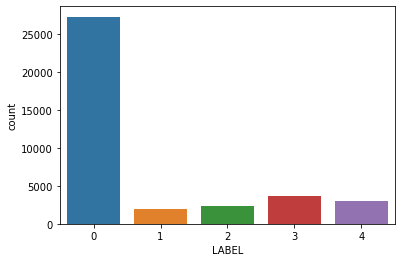

In [29]:
import seaborn as sns

sns.countplot(x='LABEL', data=pd_val_dataset)

In [30]:
pd_val_dataset.to_csv('2.2kW_ALL_validation_with_label.csv', index=False)